# Project E13 – Student Dropout Analysis
**Authors:** Villem Scheler, Aksel Nodapera

---

## 1. Introduction & Business Understanding

Student dropout is a significant challenge for higher education institutions. Leaving studies early has financial and social costs for both the student and the university. 

**Goal:** 
In this project, we analyze a real dataset of higher education students to:
1. **Analyze factors** influencing academic success or failure (demographics, socio-economics, academic performance).
2. **Visualize** these relationships to gain actionable insights.
3. **Build predictive models** (Decision Tree, KNN, Random Forest) to classify students into **Dropout**, **Enrolled**, or **Graduate** categories.

This analysis follows the **CRISP-DM** methodology: Business Understanding $\to$ Data Understanding $\to$ Data Preparation $\to$ Modeling $\to$ Evaluation.

## 2. Setup and Data Loading
We start by importing necessary libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set visual style
sns.set_style('whitegrid')

# Load dataset
df = pd.read_csv('data.csv')

# Initial column cleaning: Lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

# Verify target column exists
if 'output' not in df.columns:
    raise ValueError("Target column 'output' not found.")

# Create helper columns for visualization
# 1. 'Academic Status' for readable labels in graphs
output_map = {'Dropout': 'Dropout', 'Graduate': 'Graduate', 'Enrolled': 'Enrolled'}
df['Academic Status'] = df['output'].map(output_map)

# 2. 'IsDropout' for numerical calculations (1 = Dropout, 0 = Others)
df['IsDropout'] = df['output'].apply(lambda x: 1 if x == 'Dropout' else 0)

print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   marital_status                                4424 non-null   int64  
 1   application_mode                              4424 non-null   int64  
 2   application_order                             4424 non-null   int64  
 3   course                                        4424 non-null   int64  
 4   evening_attendance                            4424 non-null   int64  
 5   previous_qualification                        4424 non-null   int64  
 6   nacionality                                   4424 non-null   int64  
 7   mother's_qualification                        4424 non-null   int64  
 8   father's_qualification                        4424 non-null   int64  
 9   mother's_occupation               

## 3. Data Understanding & Exploratory Analysis
In this phase, we explore the data visually to understand the distribution of classes and how specific features correlate with student dropout rates.

### 3.1 Class Distribution
First, we look at the balance of our target variable `Output` (Academic Status). Understanding the baseline probability of dropout vs. graduation is crucial for evaluating model accuracy later.

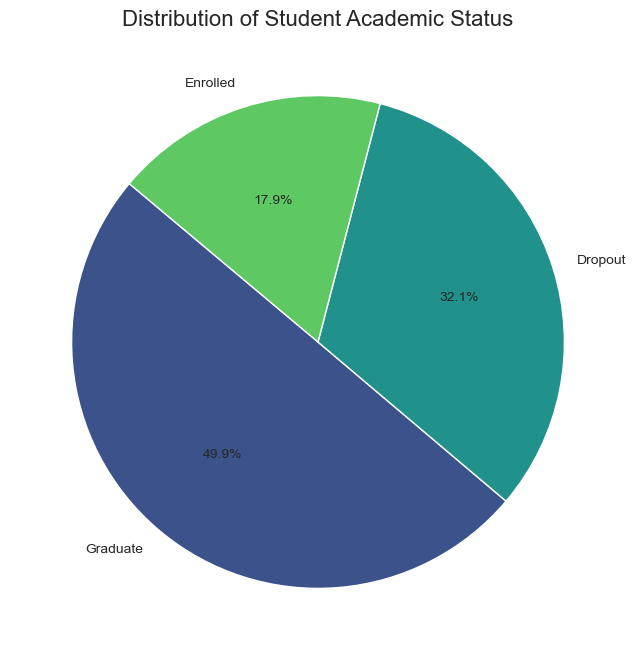

In [2]:
plt.figure(figsize=(8, 8))

# Calculate counts
status_counts = df['Academic Status'].value_counts()

# Plot Pie Chart
plt.pie(status_counts, 
        labels=status_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=sns.color_palette('viridis', len(status_counts)))

plt.title('Distribution of Student Academic Status', fontsize=16)
plt.show()

### 3.2 Age at Enrollment
Does age play a role in academic success? The KDE plot below shows the density of students at different ages for each status group.

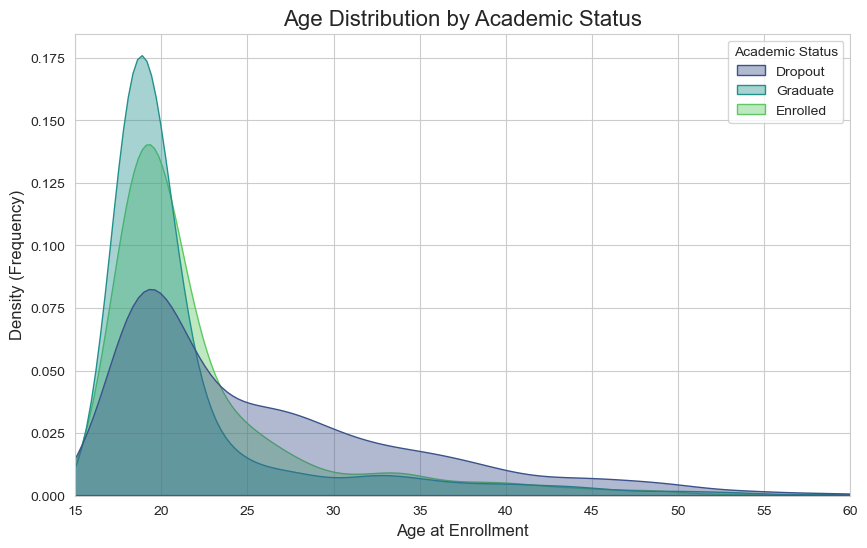

In [3]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df, 
            x='age_at_enrollment', 
            hue='Academic Status', 
            fill=True, 
            palette='viridis', 
            common_norm=False, 
            alpha=0.4)

plt.title('Age Distribution by Academic Status', fontsize=16)
plt.xlabel('Age at Enrollment', fontsize=12)
plt.ylabel('Density (Frequency)', fontsize=12)
plt.xlim(15, 60)
plt.show()

### 3.3 Gender Dynamics
We examine if there is a discrepancy in success rates between male and female students.

<Figure size 1000x600 with 0 Axes>

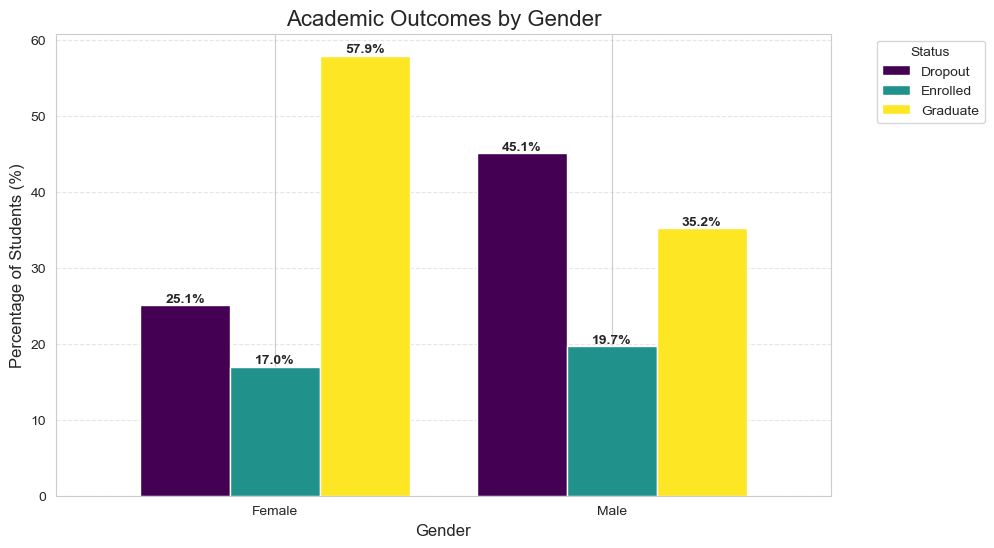

In [4]:
plt.figure(figsize=(10, 6))

# Map Gender (1 = Male, 0 = Female)
df['Gender Label'] = df['gender'].map({1: 'Male', 0: 'Female'})

# Calculate percentages
gender_status = df.groupby(['Gender Label', 'output']).size().unstack(fill_value=0)
gender_pct = gender_status.div(gender_status.sum(axis=1), axis=0) * 100
gender_pct = gender_pct[['Dropout', 'Enrolled', 'Graduate']] 

# Plot
ax = gender_pct.plot(kind='bar', figsize=(10, 6), colormap='viridis', width=0.8)

plt.title('Academic Outcomes by Gender', fontsize=16)
plt.ylabel('Percentage of Students (%)', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Labels
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

### 3.4 Marital Status
We group marital statuses into broader categories to see if family responsibilities correlate with higher dropout rates.

C:\Users\ville\AppData\Local\Temp\ipykernel_9192\2340720056.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dropout_rates.index, y=dropout_rates.values, palette='Reds')


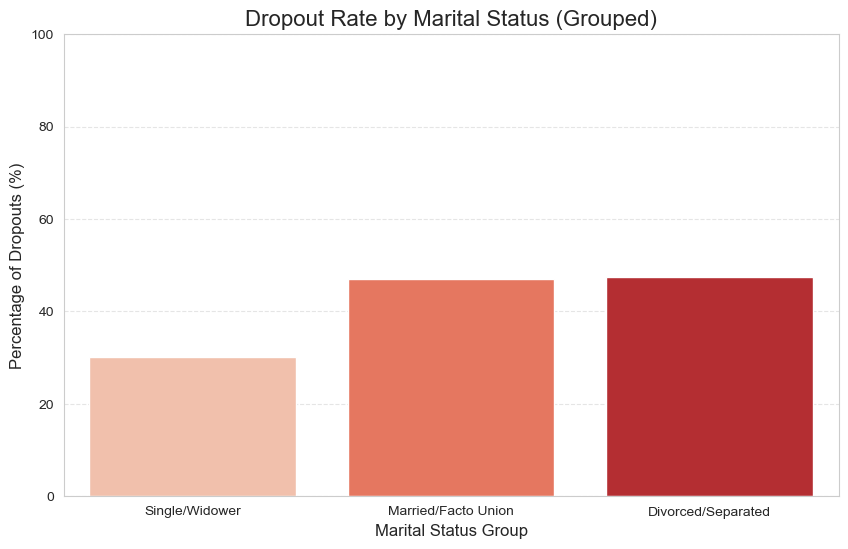

In [5]:
plt.figure(figsize=(10, 6))

# Define mapping
marital_map_merged = {
    1: 'Single/Widower', 3: 'Single/Widower',
    2: 'Married/Facto Union', 5: 'Married/Facto Union',
    4: 'Divorced/Separated', 6: 'Divorced/Separated'
}

df['Marital Status Group'] = df['marital_status'].map(marital_map_merged)

# Calculate dropout percentage
dropout_rates = df.groupby('Marital Status Group')['IsDropout'].mean() * 100
order = ['Single/Widower', 'Married/Facto Union', 'Divorced/Separated']
dropout_rates = dropout_rates.reindex(order)

# Plot
sns.barplot(x=dropout_rates.index, y=dropout_rates.values, palette='Reds')

plt.title('Dropout Rate by Marital Status (Grouped)', fontsize=16)
plt.ylabel('Percentage of Dropouts (%)', fontsize=12)
plt.xlabel('Marital Status Group', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 3.5 Course Difficulty
Different study programs have different retention rates. This chart highlights which courses have the highest dropout percentages.

C:\Users\ville\AppData\Local\Temp\ipykernel_9192\3168751928.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dropout_rates.values, y=dropout_rates.index, palette='magma')


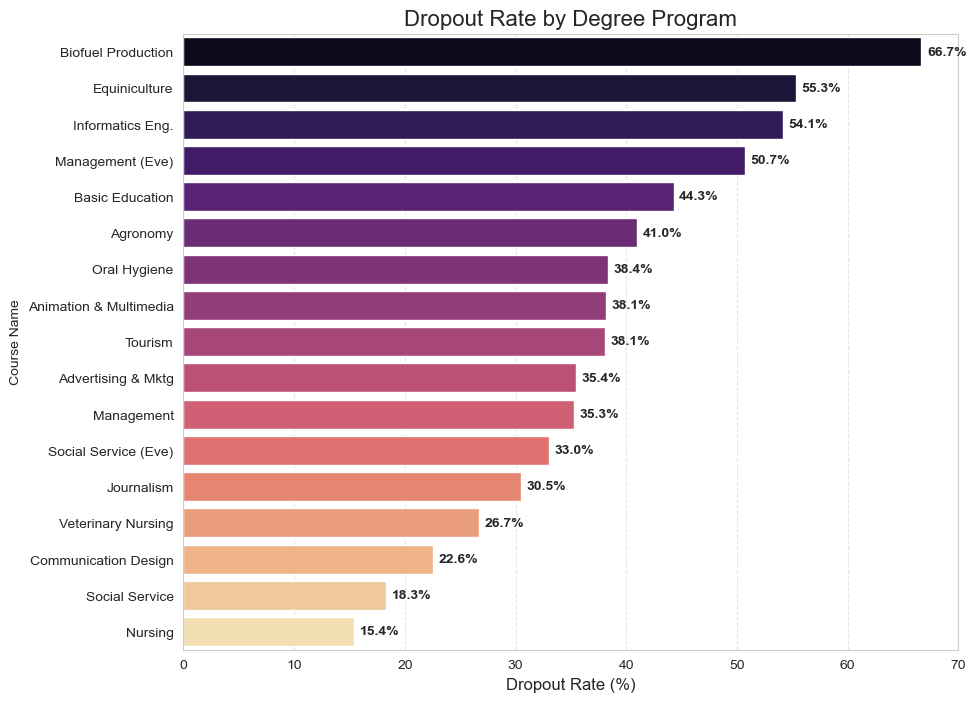

In [6]:
plt.figure(figsize=(10, 8))

# Map Codes to Names
course_map = {
    1: 'Biofuel Production', 2: 'Animation & Multimedia', 3: 'Social Service (Eve)',
    4: 'Agronomy', 5: 'Communication Design', 6: 'Veterinary Nursing',
    7: 'Informatics Eng.', 8: 'Equiniculture', 9: 'Management',
    10: 'Social Service', 11: 'Tourism', 12: 'Nursing',
    13: 'Oral Hygiene', 14: 'Advertising & Mktg', 15: 'Journalism',
    16: 'Basic Education', 17: 'Management (Eve)'
}
df['Course Name'] = df['course'].map(course_map)

# Calculate Dropout Rate
dropout_rates = df.groupby('Course Name')['IsDropout'].mean() * 100
dropout_rates = dropout_rates.sort_values(ascending=False)

# Plot
ax = sns.barplot(x=dropout_rates.values, y=dropout_rates.index, palette='magma')

plt.title('Dropout Rate by Degree Program', fontsize=16)
plt.xlabel('Dropout Rate (%)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add Labels
for i, v in enumerate(dropout_rates.values):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.show()

## 4. Data Preparation & Modeling (Main Models)

Now we prepare the data for our primary classification task using all available features. We will train two interpretable models: **Decision Tree** and **K-Nearest Neighbors (KNN)**.

In [7]:
# Drop auxiliary visualization columns to keep dataset clean
X = df.drop(columns=['output', 'Academic Status', 'IsDropout', 'Gender Label', 'Marital Status Group', 'Course Name'])
y = df['output']

# Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Target Class Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale Features (Crucial for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData shapes:", X_train.shape, X_test.shape)

Target Class Mapping: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}

Data shapes: (3539, 34) (885, 34)


### 4.1 Decision Tree Classifier
A decision tree provides clear rules for classification, making it highly interpretable.

=== Decision Tree Performance ===
Accuracy: 75.48%
              precision    recall  f1-score   support

     Dropout       0.86      0.66      0.75       284
    Enrolled       0.55      0.34      0.42       159
    Graduate       0.75      0.96      0.84       442

    accuracy                           0.75       885
   macro avg       0.72      0.66      0.67       885
weighted avg       0.75      0.75      0.74       885



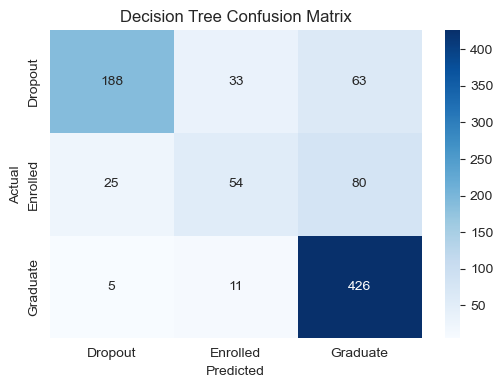

In [8]:
# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print("=== Decision Tree Performance ===")
print(f"Accuracy: {accuracy_score(y_test, dt_pred):.2%}")
print(classification_report(y_test, dt_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 4.2 K-Nearest Neighbors (KNN)
KNN classifies students based on similarity to historical examples.

=== KNN Performance ===
Accuracy: 68.93%
              precision    recall  f1-score   support

     Dropout       0.72      0.69      0.71       284
    Enrolled       0.36      0.23      0.28       159
    Graduate       0.74      0.85      0.79       442

    accuracy                           0.69       885
   macro avg       0.61      0.59      0.59       885
weighted avg       0.67      0.69      0.67       885



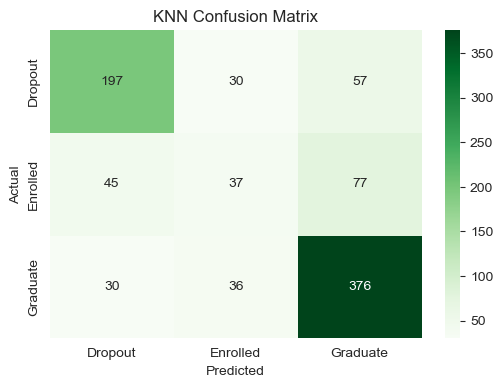

In [9]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

print("=== KNN Performance ===")
print(f"Accuracy: {accuracy_score(y_test, knn_pred):.2%}")
print(classification_report(y_test, knn_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('KNN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 4.3 Feature Importance (Decision Tree)
Which factors mattered most to the Decision Tree model?

In [10]:
feature_importance = dt.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

print("\nTop 10 Most Important Features:")
for idx in sorted_idx[:10]:
    print(f"{X.columns[idx]}: {feature_importance[idx]:.4f}")


Top 10 Most Important Features:
curricular_units_2nd_sem_approved: 0.6996
tuition_fees_up_to_date: 0.0980
curricular_units_1st_sem_enrolled: 0.0503
curricular_units_1st_sem_evaluations: 0.0319
curricular_units_2nd_sem_enrolled: 0.0314
age_at_enrollment: 0.0186
gdp: 0.0135
mother's_occupation: 0.0115
curricular_units_1st_sem_approved: 0.0097
curricular_units_2nd_sem_grade: 0.0077


## 5. Temporal Prediction Experiments (Early Detection)

To test the viability of **early warning systems**, we perform two experiments using **Random Forest**:
1. **Pre-Enrollment:** Predicting dropout using *only* data available at admission (no grades).
2. **After 1st Semester:** Predicting dropout using admission data + 1st semester performance.

### 5.1 Experiment 1: Prediction at Admission (Pre-Enrollment)
We exclude all curricular (grade) data and financial status to see how well we can predict success purely based on background.

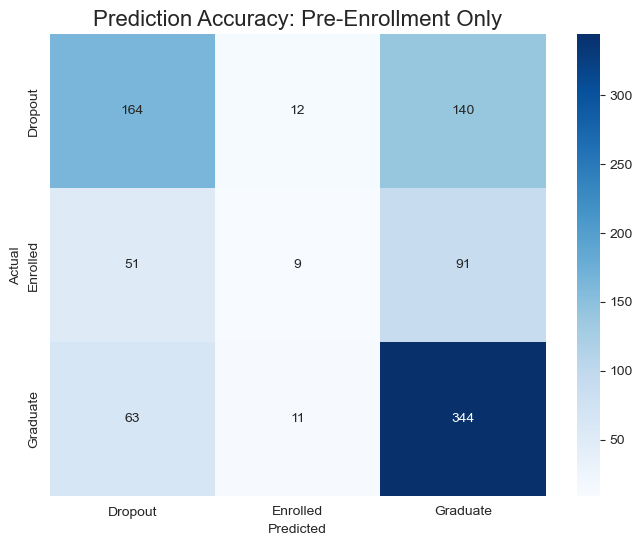

Pre-Enrollment Model Accuracy: 58.42%


In [11]:
# Define Pre-Enrollment Features
pre_enrollment_cols = [
    'marital_status', 'application_mode', 'application_order', 'course',
    'evening_attendance', 'previous_qualification', 'nacionality',
    "mother's_qualification", "father's_qualification",
    "mother's_occupation", "father's_occupation", 'displaced',
    'educational_special_needs', 'gender', 'scholarship_holder',
    'age_at_enrollment', 'international',
    'unemployment_rate', 'inflation_rate', 'gdp'
]

X_pre = df[pre_enrollment_cols].copy()
y_exp = df['output']

# Encode Categoricals
cat_cols = ['marital_status', 'application_mode', 'course', 'previous_qualification',
            'nacionality', "mother's_qualification", "father's_qualification",
            "mother's_occupation", "father's_occupation"]
for col in cat_cols:
    X_pre[col] = X_pre[col].astype(str)
X_pre = pd.get_dummies(X_pre, drop_first=True)

# Train/Test
y_enc_exp = le.fit_transform(y_exp)
X_tr, X_te, y_tr, y_te = train_test_split(X_pre, y_enc_exp, test_size=0.2, random_state=42)

# Model
rf_pre = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pre.fit(X_tr, y_tr)
y_pred_pre = rf_pre.predict(X_te)

# Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_te, y_pred_pre)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Prediction Accuracy: Pre-Enrollment Only', fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"Pre-Enrollment Model Accuracy: {accuracy_score(y_te, y_pred_pre):.2%}")

### 5.2 Experiment 2: Prediction After 1st Semester
Now we add 1st-semester grades and tuition fee status to the feature set.

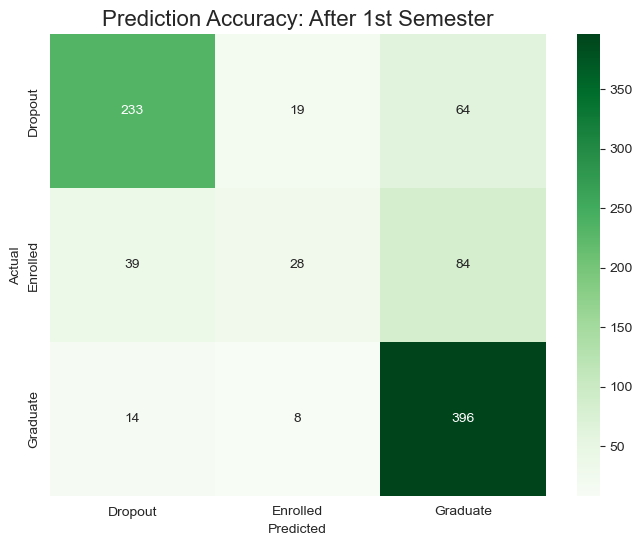

1st Semester Model Accuracy: 74.24%


In [12]:
# Add 1st Sem Features
sem1_cols = pre_enrollment_cols + [
    'debtor', 'tuition_fees_up_to_date',
    'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 
    'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 
    'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations'
]

X_sem1 = df[sem1_cols].copy()

# Encode
for col in cat_cols:
    X_sem1[col] = X_sem1[col].astype(str)
X_sem1 = pd.get_dummies(X_sem1, drop_first=True)

# Train/Test
X_tr, X_te, y_tr, y_te = train_test_split(X_sem1, y_enc_exp, test_size=0.2, random_state=42)

# Model
rf_sem1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sem1.fit(X_tr, y_tr)
y_pred_sem1 = rf_sem1.predict(X_te)

# Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_te, y_pred_sem1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Prediction Accuracy: After 1st Semester', fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"1st Semester Model Accuracy: {accuracy_score(y_te, y_pred_sem1):.2%}")

## 6. Conclusion & Recommendations

**Findings:**
1. **Pre-enrollment prediction is difficult:** Without academic performance data, accuracy is lower (~58-60%), meaning background factors alone are insufficient predictors.
2. **Early grades are critical:** Adding just 1st-semester data boosts accuracy significantly (~74%+).
3. **Key Risk Factors:** 
   - **Older age** at enrollment is linked to higher dropout.
   - **Male students** drop out more often than female students.
   - **Academic performance (approved units)** is the single strongest predictor.

**Business Impact:**
- Universities should focus on **academic monitoring** in the first semester rather than purely demographic profiling.
- **Intervention programs** (tutoring, financial aid checks) should be triggered immediately after the first set of exams to prevent dropouts.

This project demonstrates that while we can identify at-risk demographics, **student engagement (grades)** remains the most reliable indicator of success.